In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.src.utils import pad_sequences
from sklearn.model_selection import train_test_split
from custom_preprocessor import preprocess

# Get data
Pandas is used to get the data from the project directory.
The data is a .csv file, that has been created by book texts and prepared to be listed in the file word-by-word.

In [6]:
df = pd.read_csv('./data/dataset_families.csv')
df = df.sample(frac=1.0, random_state=12)
df.head()

,Word,Language Family
45885,pressaient elles appelaient,Romance
146714,hyreni rozhazuje je,Slavic
141522,odehral tehda v,Slavic
65000,te equivocas severus,Romance
80966,die genossenschaft,Germanic


# Prepare data
Divide the data into X and y. X is input and y is the desired output.
One-Hot Encode it, so the language is categorical. This is done with Pandas.

In [7]:
# Getting X - the input values
X = df.iloc[:, :-1]
X.loc[:, 'Word'] = X['Word'].astype(str)
tokenizer = Tokenizer(char_level=True) # Used for turning the words into numbers
tokenizer.fit_on_texts(X['Word'].tolist()) # Giving Tokenizer the data it needs to learn how to encode the words
X_sequences = tokenizer.texts_to_sequences(X['Word'].tolist()) # Now the words are encoded into sequences
input_dim = max(len(seq) for seq in X_sequences)
X = pad_sequences(
    X_sequences, 
    maxlen=input_dim, 
    padding='post'
) # Making all input values be of same length
print(f"Rows: {len(X)}")

# Getting y - the output values
y_df = pd.get_dummies(df.iloc[:, -1:])
y = y_df.values
print(f"Amount of languages to identify: {len(y[1])}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

Rows: 187795
Amount of languages to identify: 5


In [8]:
model = Sequential()
model.add(Conv1D(input_dim, 2, activation='relu'))  # Convolutional layer
tf.keras.layers.SimpleRNN(8, activation='relu')
model.add(LSTM(64, return_sequences=True))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(len(y[1]), activation='softmax'))
adam = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [9]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=2048,verbose=1)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.2875 - loss: 1.6659 - val_accuracy: 0.4278 - val_loss: 1.3547
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 0.4323 - loss: 1.3392 - val_accuracy: 0.4731 - val_loss: 1.2579
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.4788 - loss: 1.2536 - val_accuracy: 0.5315 - val_loss: 1.1488
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.5308 - loss: 1.1507 - val_accuracy: 0.5812 - val_loss: 1.0443
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.5864 - loss: 1.0400 - val_accuracy: 0.6224 - val_loss: 0.9576
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.6287 - loss: 0.9495 - val_accuracy: 0.6691 - val_loss: 0.8547
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.6730 - loss: 0.8508 - val_accuracy: 0.7089 - val_loss: 0.7671
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.7019 - loss: 0.7808 - val_accu

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

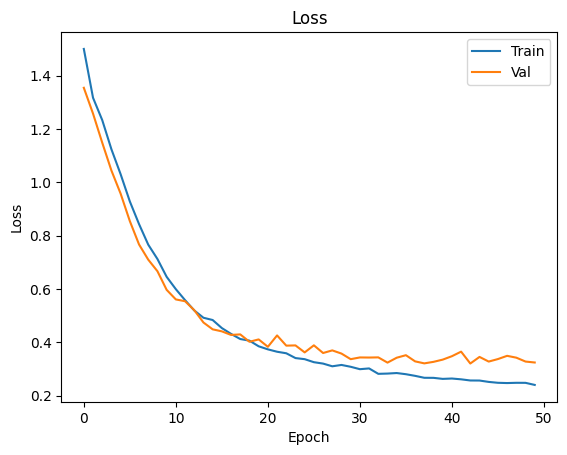

In [15]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

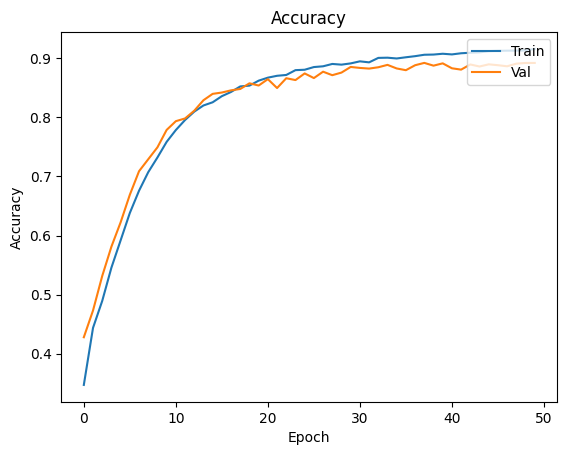

In [11]:
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Prediction

In [16]:
prediction_word = "Hvaðan eru tygum Hvaðan eru tygum Hvaðan eru tygum"
print(f"Text before preprocessing: {prediction_word}")
prediction_word = preprocess(prediction_word)
print(f"Text after preprocessing: {prediction_word}")
prediction_word = tokenizer.texts_to_sequences([prediction_word])
prediction_word = pad_sequences(prediction_word, maxlen=input_dim)
prediction = model.predict([prediction_word])
output_probabilities = np.array(prediction)
result = {}
class_labels = np.unique(y_df.columns)
for index, prediction in enumerate(output_probabilities[0]):
    result.update({class_labels[index]: round(prediction * 100, 1)})

# Print keys and values of the result dictionary
for key, value in result.items():
    print(f"{key}: {value}")

Text before preprocessing: Hvaðan eru tygum Hvaðan eru tygum Hvaðan eru tygum
Text after preprocessing: hvadan eru tygum hvadan eru tygum hvadan eru tygum
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Language Family_Germanic: 58.3
Language Family_Hellenic: 0.0
Language Family_Romance: 0.1
Language Family_Slavic: 17.1
Language Family_Uralic: 24.4


# Save model
Here a model can be loaded

In [13]:
model.save('./model_lang_families.keras')

# Load model
Here a model can be loaded

In [14]:
model = load_model('./model_lang_families.keras')